In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = datasets.CIFAR10(root = 'dataset/',train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = 'dataset/',train = False, download = True, transform = transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 30409451.80it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [16]:
def get_indeces(dataset, classes) -> list:
    class_count = {cls: 0 for cls in classes}
    subset_indexes = []

    for i in range(len(dataset)):
        x, y = dataset[i]
        if y in classes and (class_count[y] < 100):
            subset_indexes.append(i)
            class_count[y] += 1

    return subset_indexes

In [17]:
first_subset_idx = get_indeces(train_dataset,[0,1,2,3,4])
second_subset_idx = get_indeces(train_dataset,[5,6,7,8,9])

print(len(first_subset_idx))
print(len(second_subset_idx))

first_subset = Subset(dataset=train_dataset,indices=first_subset_idx)
second_subset = Subset(dataset=train_dataset,indices=second_subset_idx)

500
500


In [18]:
class CustomDataset(Dataset):
    def __init__(self,first_dataset,second_dataset):
        super(CustomDataset,self).__init__()
        self.first = first_dataset
        self.second = second_dataset

    def __len__(self):
        return 4 * (len(self.first) + len(self.second))

    def __getitem__(self,idx):
        rand_1 = np.random.randint(len(self.first))
        rand_2 = np.random.randint(len(self.second))

        x_1,_ = self.first[rand_1]
        x_2,_ = self.second[rand_2]

        mean_x = (x_1 + x_2)/2

        return x_1, x_2, mean_x

In [19]:
custom_dataset = CustomDataset(first_subset,second_subset)
custom_loader = DataLoader(dataset = custom_dataset,batch_size = 32,shuffle = True,pin_memory=True)

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder_1 = nn.ModuleList()
        self.decoder_2 = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.decoder_1.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder_1.append(DoubleConv(feature * 2, feature))

            self.decoder_2.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder_2.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv_1 = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final_conv_2 = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for conv in self.encoder:
            x = conv(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # First Decoder
        out_1 = x
        for idx in range(0, len(self.decoder_1), 2):
            out_1 = self.decoder_1[idx](out_1)
            skip_connection = skip_connections[idx // 2]

            if out_1.shape != skip_connection.shape:
                out_1 = transforms.functional.resize(out_1, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, out_1), dim=1)
            out_1 = self.decoder_1[idx + 1](concat_skip)

        # Second Decoder
        out_2 = x
        for idx in range(0, len(self.decoder_2), 2):
            out_2 = self.decoder_2[idx](out_2)
            skip_connection = skip_connections[idx // 2]

            if out_2.shape != skip_connection.shape:
                out_2 = transforms.functional.resize(out_2, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, out_2), dim=1)
            out_2 = self.decoder_2[idx + 1](concat_skip)

        return torch.sigmoid(self.final_conv_1(out_1)), torch.sigmoid(self.final_conv_2(out_2))


In [24]:
unet = UNET(in_channels=3, out_channels=3, features=[32,64,128,256]).to(device)
optimizer = optim.Adam(unet.parameters(),lr = 0.001)
criterion = nn.MSELoss()

In [25]:
epochs = 1_000
losses = []

unet.train()

progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")

for epoch in progress_bar:

    train_loss = 0.0
    for x_1, x_2, mean_x in custom_loader:

        x_1, x_2, mean_x = x_1.to(device), x_2.to(device), mean_x.to(device)

        optimizer.zero_grad()

        output_1, output_2 = unet(mean_x)

        loss_1 = criterion(x_1, output_1)
        loss_2 = criterion(x_2, output_2)

        loss = loss_1 + loss_2

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    losses.append(train_loss)

    progress_bar.set_postfix(loss=train_loss)

plt.plot(range(epochs), losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

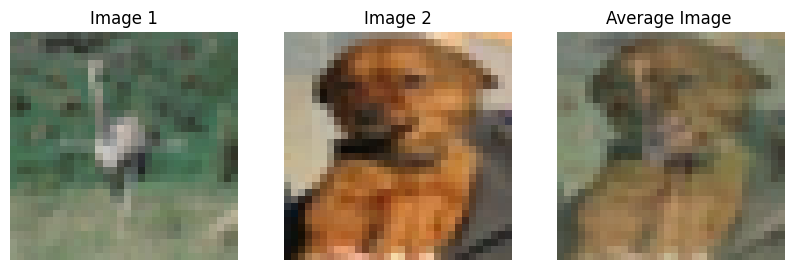

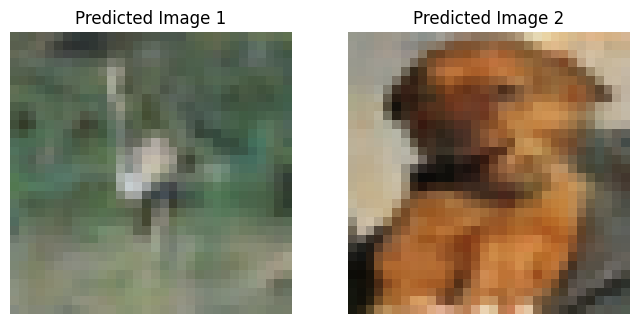

In [34]:
import random

def test_model(image_1,image_2, mean_image):

    fig, ax = plt.subplots(1,3,figsize=(10,5))

    ax[0].imshow(image_1)
    ax[0].set_title('Image 1')
    ax[0].axis('off')

    ax[1].imshow(image_2)
    ax[1].set_title('Image 2')
    ax[1].axis('off')

    ax[2].imshow(mean_image)
    ax[2].axis('off')
    ax[2].set_title('Average Image ')


    mean = torch.permute(mean_image,[2,0,1])
    mean = torch.unsqueeze(mean,0).to(device)

    unet.eval()

    output1, output2 = unet(mean)

    output1 = torch.permute(output1.squeeze(0),[1,2,0]).detach().cpu().numpy()
    output2 = torch.permute(output2.squeeze(0),[1,2,0]).detach().cpu().numpy()


    fig, ax = plt.subplots(1,2,figsize=(8,5))

    ax[0].imshow(output1)
    ax[0].set_title('Predicted Image 1')
    ax[0].axis('off')

    ax[1].imshow(output2)
    ax[1].set_title('Predicted Image 2')
    ax[1].axis('off')

    plt.show()
    

(x_1, _), (x_2, _) = first_subset[random.randint(0, len(first_subset) - 1)], second_subset[random.randint(0, len(second_subset) - 1)]

img_1 = torch.permute(x_1, [1, 2, 0])
img_2 = torch.permute(x_2, [1, 2, 0])
mean_img = (img_1 + img_2) / 2

test_model(img_1, img_2, mean_img)

In [36]:
first_subset_idx_test = get_indeces(test_dataset,[0,1,2,3,4])
second_subset_idx_test = get_indeces(test_dataset,[5,6,7,8,9])

print(len(first_subset_idx_test))
print(len(second_subset_idx_test))

first_subset_test = Subset(dataset=test_dataset,indices=first_subset_idx_test)
second_subset_test = Subset(dataset=test_dataset,indices=second_subset_idx_test)

ctest_dataset = CustomDataset(first_subset_test,second_subset_test)
test_loader = DataLoader(dataset = ctest_dataset,batch_size = 32,shuffle = True,pin_memory=True)

500
500


In [37]:
unet.eval()

test_loss = 0.0
total_test_samples = 0

with torch.no_grad():
    for x_1, x_2, mean_x in test_loader:
        x_1 = x_1.to(device)
        x_2 = x_2.to(device)
        mean_x = mean_x.to(device)

        output_1, output_2 = unet(mean_x)

        loss_1 = criterion(x_1, output_1)
        loss_2 = criterion(x_2, output_2)
        loss = loss_1 + loss_2

        test_loss += loss.item()
        total_test_samples += x_1.size(0)

average_test_loss = test_loss / total_test_samples
print(f'Average Test Loss: {average_test_loss:.4f}')

Average Test Loss: 0.0025
